# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Признаки:</b>

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

<b>Целевой признак:</b>

    Price — цена (евро)

In [3]:
import lightgbm as lgb

/Users/ivanovaleksandr/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
from catboost import CatBoostRegressor

## Подготовка данных

In [5]:
#Импортируем необходимые библиотеки
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
import numpy as np
from numpy.linalg import inv
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [6]:
#Посмотрим на данные
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

def lookup(data):
    print(data.info())
    print()
    print(data.head(10))
    print()
    print(data.duplicated().sum())
    print()
    print(data.nunique())
    print()
    print(data.isna().sum())

lookup(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None

           DateCrawled  Price  VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480          NaN              

И так:

    - NumberOfPictures - колонка говорит, о том что ни у одного автомобиля нет ни одной фотографии. Конкретно в такой выборке эта колонка бессмыслена для обучения.
    - Огромное количество пропусков в VehicleType, Gearbox, Model, FuelType, NotRepaired. Даные всех этих колонок категориальные. Отсутствие категории тоже категория. Далее поправим.
    - 4 Полных дубля на всю выборку. Очень маленькое число, можно пропустить.
    - Типы данных очень разные. Есть даты. Ох уж эти даты. Колонка Brand категориальные данные типа object.

In [7]:
# Уберем колонку NumberOfPictures

df_clean = df.drop(['NumberOfPictures'],axis=1)

#Представим даныне в VehicleType, Gearbox, Model, FuelType, NotRepaired, Brand
#интовыми категориями (почему бы и нет)
#Пропуски сделаем категорией

def categorize(data, column):
    data[column] = data[column].fillna('propuskov.net')
    data[column] = pd.Categorical(data[column], categories=data[column].unique()).codes
    data[column] = data[column].astype(int)
        
categorize(df_clean, 'VehicleType')
categorize(df_clean, 'Gearbox')
categorize(df_clean, 'FuelType')
categorize(df_clean, 'Model')
categorize(df_clean, 'NotRepaired')
categorize(df_clean, 'Brand')


""""
# Разберемся с датами DateCrawled, DateCreated, LastSeen
# Воспользуемся советами статьи 
# https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/
# Ребята предлагают представлять временые ряды как базовые признаки
# То есть колонку с датой можно представить как несколько колонок с категориальными признакми, как Год/Месяц/...
# Напишем функцию автоматизации этого процесса


def datetocat(data, column):
    data[column] = pd.to_datetime(data[column],format='%Y-%m-%d %H:%M')
    data['$year'] = data[column].dt.year 
    data['$month'] = data[column].dt.month 
    data['$day'] = data[column].dt.day
    data['$dayofweek_num'] = data[column].dt.dayofweek
    data['$Hour'] = data[column].dt.hour 
    data['$minute'] = data[column].dt.minute
    data.columns = data.columns.str.replace('$', column + '_')
    #Оригинальную колонку с датой удалим
    data = data.drop(column, axis=1, inplace=True)
    return data

datetocat(df_clean, 'DateCrawled')
datetocat(df_clean, 'DateCreated')
datetocat(df_clean, 'LastSeen')
"""

#Удалим следующие колонки:
#DateCrawled — дата скачивания анкеты из базы
#DateCreated — дата создания анкеты
#LastSeen — дата последней активности пользователя
#PostalCode - почтовый индекс владельца анкеты (пользователя)
#Избыточные признаки не несут информации для модели обучения и увеличивают время обучения.

df_clean = df_clean.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'], axis=1)

print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
Price                354369 non-null int64
VehicleType          354369 non-null int64
RegistrationYear     354369 non-null int64
Gearbox              354369 non-null int64
Power                354369 non-null int64
Model                354369 non-null int64
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             354369 non-null int64
Brand                354369 non-null int64
NotRepaired          354369 non-null int64
dtypes: int64(11)
memory usage: 29.7 MB
None


In [8]:
# Посмотрим на столбец RegistrationMonth
sorted(df_clean.RegistrationMonth.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [9]:
#Т.к. 0 недопустимое значение признака RegistrationMonth, и, вероятно, возникло из за того, 
#что владелец не указал месяц регистрации авто, заменим на Январь(т.е. 1):

df_clean.RegistrationMonth = df_clean.RegistrationMonth.replace(0, 1, inplace=False)
sorted(df_clean.RegistrationMonth.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [10]:
## Посмотрим на столбец RegistrationYear
sorted(df_clean.RegistrationYear.unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

In [11]:
#Выведем df с признаком RegistrationYear, у которого год указан аномальным значением:

invalid_year = df_clean[(df_clean.RegistrationYear < 1910) | (df_clean.RegistrationYear > 2019)]
invalid_year

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
622,0,0,1111,2,0,1,5000,1,2,11,0
12946,49,0,5000,2,0,0,5000,12,2,0,0
15147,0,0,9999,2,0,1,10000,1,2,19,0
15870,1700,0,3200,2,0,1,5000,1,2,19,0
16062,190,0,1000,2,0,76,5000,1,2,6,0
...,...,...,...,...,...,...,...,...,...,...,...
340548,0,0,3500,0,75,1,5000,3,0,19,0
340759,700,0,1600,0,1600,69,150000,4,0,1,2
341791,1,0,3000,2,0,74,5000,1,2,11,0
348830,1,0,1000,2,1000,1,150000,1,2,19,0


In [12]:
#Количество объектов 171, что составляет < 0.01 % всех объектов. 
#Удалим объекты с аномальными значениями по индексам.

df_clean.drop(invalid_year.index, inplace=True)

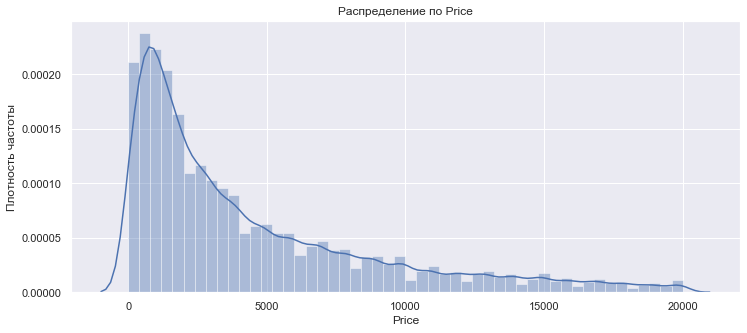

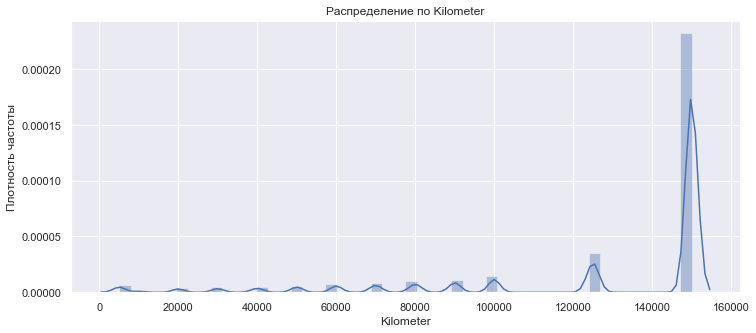

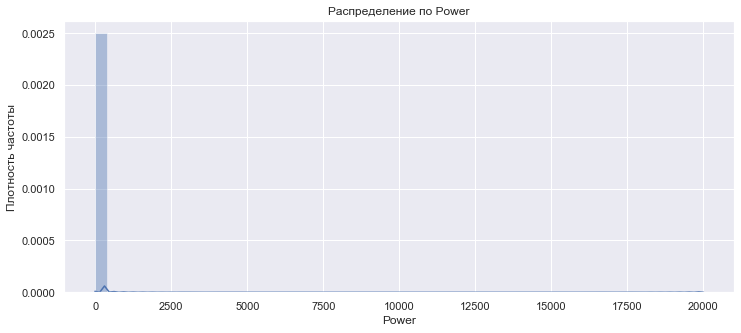

In [13]:
#Посмотрим на колонки Price, Power, Kilometer

numeric_feature = set(('Price', 'Power', 'Kilometer'))
def numeric_feature_distribution(column):
    sns.set()
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.distplot(df_clean[column])
    ax.set_title('Распределение по ' + column)
    plt.ylabel('Плотность частоты');

[numeric_feature_distribution(item) for item in numeric_feature];

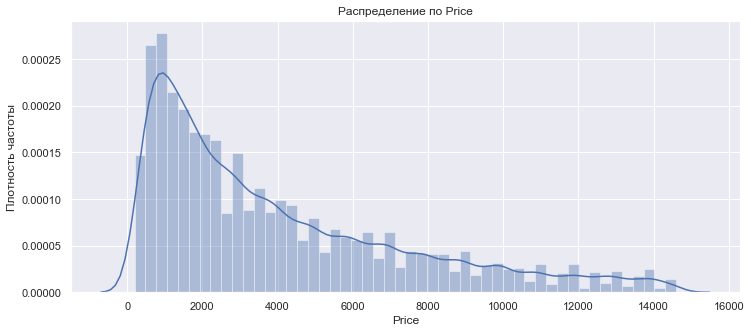

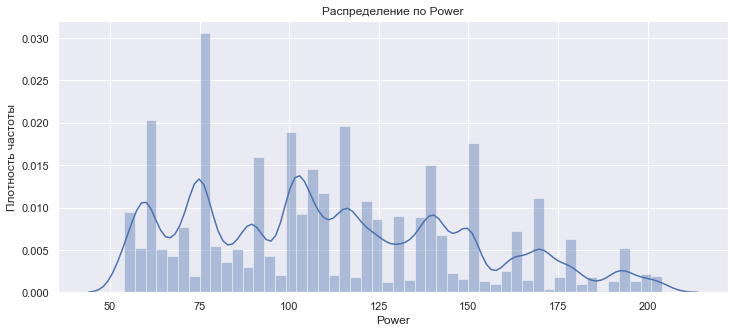

In [14]:
#Признак Kilometer относиться больше к категориальным признакам, удалим из переменной:
numeric_feature.discard('Kilometer')
numeric_feature

#Посмотрим на распределения в признаке Price:
df_clean.Price.describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])
#Ограничим распределение 5% и 95% квантилями, исключив аномальные значения:
invalid_price = df_clean[(df_clean.Price < df_clean.Price.quantile(.05)) | (df_clean.Price > df_clean.Price.quantile(.95))]
invalid_price.shape
df_clean.drop(invalid_price.index, inplace=True)

#Посмотрим на распределения в признаке Power:
df_clean.Power.describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])
#Мощность двигателя ниже 15% и выше 95% квантилей, является аномальным. Удалим их из респределения:
invalid_power = df_clean[(df_clean.Power < df_clean.Power.quantile(.15)) | (df_clean.Power > df_clean.Power.quantile(.95))]
invalid_power.shape
df_clean.drop(invalid_power.index, inplace=True)

#Снова построим графики количественных признаков:
[numeric_feature_distribution(item) for item in numeric_feature];

In [15]:
#Чтобы преобразовать категориальные признаки в численные поможет техника прямого кодирования
#(One-Hot Encoding, OHE). Для прямого кодирования в библиотеке pandas есть функция pd.get_dummies()
#чтобы избежать дамми-ловушки, используем аргумент drop_first=True

#Для бустинга сохраним датасет без OHE

df_boost = df_clean.copy()


df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
2,9800,2,2004,1,163,2,125000,8,1,2,0
3,1500,3,2001,0,75,0,150000,6,0,0,2
4,3600,3,2008,0,69,3,90000,7,1,3,2
5,650,4,1995,0,102,4,150000,10,0,4,1
6,2200,5,2004,0,109,5,150000,8,0,5,2
...,...,...,...,...,...,...,...,...,...,...,...
354359,7900,4,2010,0,140,0,150000,7,1,0,2
354361,5250,0,2016,1,150,130,150000,12,2,20,2
354366,1199,5,2000,1,101,29,125000,3,0,17,2
354367,9200,6,1996,0,102,21,150000,3,1,0,2


### Вывод:

    Данные предобработаны. Избыточные и аномальные признаки удалены, количественные признаки преобразованы в категориальыне

## Обучение моделей

In [16]:
# Подготовим выборки
# Масштабируем признаки
# Сделаем это конечно же функцией

def preparation(data, point):
    
    train, valid_test = train_test_split(data, test_size=0.4, random_state=12345)
    valid, test = train_test_split(valid_test, test_size=0.5, random_state=12345)
    
    def features_target_split(data, point):
        features = data.drop([point], axis=1)
        target = data[point]
        return features, target

    train_features, train_target = features_target_split(train, point)
    valid_features, valid_target = features_target_split(valid, point)
    test_features, test_target = features_target_split(test, point)
    
    def data_to_StandardScaler(data, train_features):
        scaler = StandardScaler()
        scaler.fit(train_features)
        data = scaler.transform(data)
        return data
    
    valid_features_scale = data_to_StandardScaler(valid_features, train_features)
    train_features_scale = data_to_StandardScaler(train_features, train_features)
    test_features_scale = data_to_StandardScaler(test_features, train_features)
    
    return train_target, valid_target, test_target,valid_features_scale, train_features_scale, test_features_scale

#train_target, valid_target, test_target,valid_features_scale, train_features_scale, test_features_scale = preparation(df_clean, 'Price')

#Подготовим код метрики

def rmse(predict, target):
    mse = mean_squared_error(target, predict)
    rmse = mse ** 0.5
    return rmse
    
score = make_scorer(rmse, greater_is_better=False)    

In [17]:
%%time

# Посмотрим на решающее дерево
# Для начала подберем параметры

def tree(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
    parameters_grid = {}
    """
    parameters_grid = {
    'max_depth' : range(1,6),
    'min_samples_leaf': range(1,6),
    'min_samples_split': range(1,6),
    'min_samples_split': range(1,6)
    }
    """
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    grid_cv = GridSearchCV(model, parameters_grid, scoring=score, n_jobs=-1, cv=cv)
    grid_cv.fit(train_features_scale, train_target)
    grid_cv.best_estimator_
    print(grid_cv.best_score_)
    print(grid_cv.best_params_)

tree(df_clean, 'Price')
    

-2015.3364596165056
{}
CPU times: user 7.23 s, sys: 1.77 s, total: 9 s
Wall time: 24.1 s


In [18]:
#Проверим скорость и качество Решающего дерева по лучшим параметрам

def tree_check(data,point):
    (train_target, 
         valid_target, 
         test_target, 
         valid_features_scale, 
         train_features_scale, 
         test_features_scale) = preparation(data, point)
     
    model = DecisionTreeClassifier(random_state=12345, class_weight='balanced', 
                               criterion='entropy', max_depth = 3, min_samples_leaf = 5, 
                               min_samples_split = 2)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyClassifier(strategy='uniform', random_state=12345)
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

tree_check(df_clean, 'Price')

Скорость обучения:
CPU times: user 222 ms, sys: 3.15 ms, total: 225 ms
Wall time: 225 ms
----------
Скорость предсказания:
CPU times: user 136 ms, sys: 182 ms, total: 317 ms
Wall time: 317 ms
----------
RMSE модели : 4787.00
----------
RMSE модели на тестовой выборке : 4799.70
----------
RMSE модели(кросс-валидация) : 4654.44
----------
Скорость обучения дамми-модели:
CPU times: user 6.86 ms, sys: 111 µs, total: 6.97 ms
Wall time: 6.81 ms
----------
Скорость предсказания дамми-модели:
CPU times: user 1.28 ms, sys: 118 µs, total: 1.4 ms
Wall time: 1.21 ms
----------
RMSE дамми-модели : 5545.80


In [19]:
%%time

# Посмотрим на случайный лес
# Подберем параметры
# Тут мой ноут откровенно дал дубу, так что, для подбора параметров, я немжко сократил датасет в 10 раз

def forest(data,point):
    data = data.sample(frac = 0.1, random_state=12345)
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = RandomForestClassifier(random_state=12345, class_weight='balanced')
    parameters_grid = {
    'n_estimators' : range(5, 101, 5),
    'max_depth' : range(1, 11)
    }
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    grid_cv = GridSearchCV(model, parameters_grid, scoring=score, n_jobs=-1, cv=cv)
    grid_cv.fit(train_features_scale, train_target)
    grid_cv.best_estimator_
    print(grid_cv.best_score_)
    print(grid_cv.best_params_)

forest(df_clean, 'Price')

-2971.003045157606
{'max_depth': 10, 'n_estimators': 95}
CPU times: user 5.86 s, sys: 1.55 s, total: 7.42 s
Wall time: 2min 35s


In [20]:
#Проверим скорость и качество Случайного леса по лучшим параметрам

def forest_check(data,point):
    (train_target, 
         valid_target, 
         test_target, 
         valid_features_scale, 
         train_features_scale, 
         test_features_scale) = preparation(data, point)
     
    model = RandomForestClassifier(random_state=12345, class_weight='balanced', 
                               criterion='entropy', max_depth = 10, n_estimators = 95)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyClassifier(strategy='uniform', random_state=12345)
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

forest_check(df_clean, 'Price')

Скорость обучения:
CPU times: user 31.7 s, sys: 1.16 s, total: 32.9 s
Wall time: 33 s
----------
Скорость предсказания:
CPU times: user 31.9 s, sys: 1min, total: 1min 32s
Wall time: 2min 3s
----------
RMSE модели : 2386.74
----------
RMSE модели на тестовой выборке : 2416.41
----------
RMSE модели(кросс-валидация) : 2406.51
----------
Скорость обучения дамми-модели:
CPU times: user 7.37 ms, sys: 1.64 ms, total: 9.01 ms
Wall time: 8.85 ms
----------
Скорость предсказания дамми-модели:
CPU times: user 1.36 ms, sys: 402 µs, total: 1.77 ms
Wall time: 1.57 ms
----------
RMSE дамми-модели : 5545.80


In [21]:
%%time

# Посмотрим на регресивное дерево


def tree_regressor(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = DecisionTreeRegressor(random_state=12345)
    parameters_grid = {
    'max_depth' : range(1,6),
    'min_samples_leaf': range(1,6),
    'min_samples_split': range(1,6),
    }
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    grid_cv = GridSearchCV(model, parameters_grid, scoring=score, n_jobs=-1, cv=cv)
    grid_cv.fit(train_features_scale, train_target)
    grid_cv.best_estimator_
    print(grid_cv.best_score_)
    print(grid_cv.best_params_)

tree_regressor(df_clean, 'Price')

-1990.4531821366252
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
CPU times: user 1.23 s, sys: 528 ms, total: 1.76 s
Wall time: 22.5 s


In [22]:
#Проверим скорость и качество Дерево регрессии по лучшим параметрам

def tree_regressor_check(data,point):
    (train_target, 
         valid_target,
         test_target, 
         valid_features_scale, 
         train_features_scale, 
         test_features_scale) = preparation(data, point)
     
    model = DecisionTreeRegressor(random_state=12345, 
                               criterion='squared_error', max_depth = 5, min_samples_leaf = 1, 
                               min_samples_split = 2)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyRegressor(strategy = 'mean')
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

tree_regressor_check(df_clean, 'Price')

Скорость обучения:
CPU times: user 134 ms, sys: 2.05 ms, total: 137 ms
Wall time: 137 ms
----------
Скорость предсказания:
CPU times: user 2.67 ms, sys: 244 µs, total: 2.91 ms
Wall time: 2.72 ms
----------
RMSE модели : 1947.30
----------
RMSE модели на тестовой выборке : 1974.94
----------
RMSE модели(кросс-валидация) : 1982.36
----------
Скорость обучения дамми-модели:
CPU times: user 268 µs, sys: 26 µs, total: 294 µs
Wall time: 266 µs
----------
Скорость предсказания дамми-модели:
CPU times: user 81 µs, sys: 15 µs, total: 96 µs
Wall time: 112 µs
----------
RMSE дамми-модели : 3419.21


In [23]:
%%time

# Посмотрим на регрессивный лес
# И тут мой ноут откровенно дал дубу, так что, для подбора параметров, я немжко сократил датасет в 10 раз


def forest_regressor(data,point):
    data = data.sample(frac = 0.1, random_state=12345)
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = RandomForestRegressor(random_state=12345)
    parameters_grid = {
    'n_estimators' : range(5, 101, 5),
    'max_depth' : range(1, 11)
    }
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    grid_cv = GridSearchCV(model, parameters_grid, scoring=score, n_jobs=-1, cv=cv)
    grid_cv.fit(train_features_scale, train_target)
    grid_cv.best_estimator_
    print(grid_cv.best_score_)
    print(grid_cv.best_params_)

forest_regressor(df_clean, 'Price')

-1552.4527020764642
{'max_depth': 10, 'n_estimators': 100}
CPU times: user 4.36 s, sys: 287 ms, total: 4.65 s
Wall time: 1min 5s


In [24]:
#Проверим скорость и качество Леса регрессий по лучшим параметрам

def forest_regressor_check(data,point):
    (train_target, 
         valid_target, 
         test_target, 
         valid_features_scale, 
         train_features_scale, 
         test_features_scale) = preparation(data, point)
     
    model = RandomForestRegressor(random_state=12345, 
                               criterion='squared_error', max_depth = 10,
                                  n_estimators = 100, n_jobs =-1)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyRegressor(strategy = 'mean')
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

forest_regressor_check(df_clean, 'Price')

Скорость обучения:
CPU times: user 27.9 s, sys: 290 ms, total: 28.2 s
Wall time: 4.33 s
----------
Скорость предсказания:
CPU times: user 487 ms, sys: 6.07 ms, total: 493 ms
Wall time: 104 ms
----------
RMSE модели : 1491.80
----------
RMSE модели на тестовой выборке : 1513.61
----------
RMSE модели(кросс-валидация) : 1514.40
----------
Скорость обучения дамми-модели:
CPU times: user 346 µs, sys: 42 µs, total: 388 µs
Wall time: 321 µs
----------
Скорость предсказания дамми-модели:
CPU times: user 113 µs, sys: 20 µs, total: 133 µs
Wall time: 138 µs
----------
RMSE дамми-модели : 3419.21


In [25]:
# Посмотрим на линейную регрессию


def line_regressor(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = LinearRegression(n_jobs=-1)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyRegressor(strategy = 'mean')
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

line_regressor(df_clean, 'Price')

Скорость обучения:
CPU times: user 66.7 ms, sys: 26.5 ms, total: 93.2 ms
Wall time: 35.6 ms
----------
Скорость предсказания:
CPU times: user 13.4 ms, sys: 4.21 ms, total: 17.7 ms
Wall time: 3.63 ms
----------
RMSE модели : 2389.45
----------
RMSE модели на тестовой выборке : 2402.92
----------
RMSE модели(кросс-валидация) : 2407.02
----------
Скорость обучения дамми-модели:
CPU times: user 1.81 ms, sys: 645 µs, total: 2.45 ms
Wall time: 332 µs
----------
Скорость предсказания дамми-модели:
CPU times: user 901 µs, sys: 520 µs, total: 1.42 ms
Wall time: 234 µs
----------
RMSE дамми-модели : 3419.21


In [26]:
"""
# Посмотрим на логистическую регрессию
# И тут мой ноут откровенно дал дубу, так что я немжко сократил датасет в 5 раз

def log_regressor(data,point):
    data = data.sample(frac = 0.2, random_state=12345, axis=0)
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = LogisticRegression(random_state=12345, class_weight='balanced', n_jobs=-1)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyRegressor(strategy = 'mean')
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

log_regressor(df_clean, 'Price')
"""

"\n# Посмотрим на логистическую регрессию\n# И тут мой ноут откровенно дал дубу, так что я немжко сократил датасет в 5 раз\n\ndef log_regressor(data,point):\n    data = data.sample(frac = 0.2, random_state=12345, axis=0)\n    (train_target, \n     valid_target, \n     test_target, \n     valid_features_scale, \n     train_features_scale, \n     test_features_scale) = preparation(data, point)\n    model = LogisticRegression(random_state=12345, class_weight='balanced', n_jobs=-1)\n    # Посмотрим на скорость обучения модели и скорость предсказания\n    print('Скорость обучения:')\n    %time model.fit(train_features_scale, train_target)\n    print('----------')\n    print('Скорость предсказания:')\n    %time model.predict(valid_features_scale)\n    prediction = model.predict(valid_features_scale)\n    print('----------')\n    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))\n    print('----------')\n    # Посмотрим как модель работает на тестовой выборке\n    model.fit

In [27]:
"""
%%time

# Посмотрим на бустинг
# Учитывая что ранее лучгший результат был у Леса регрессий, то в параметры бустера lightGBM укажем регрессию
# не смотря на то что она идет по умолчанию, к тому же под метрику rmse подходит regression_L2
# Для начала попробуем Gradient Boosting Decision Tree

(train_target, 
valid_target, 
test_target, 
valid_features_scale, 
train_features_scale, 
test_features_scale) = preparation(df_clean, 'Price')


def gbm_model(train_x, train_y, validation_x, validation_y, test_x):
    params = {
        "boosting" : "gbdt",
        "objective" : "regression",
        "metric" : "rmse",  
    }
    
    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=validation_y)
    #Создадим пустой список, куда будем записывать оценки результатов тренировочной выборки и валидационной
    evals_result_lgbm = {}

    model = lgb.train(params, lg_train, 5000,
                      valid_sets=[lg_train, lg_validation],
                      #Воспользуемся штатным Early Stopping
                      early_stopping_rounds=100,
                      verbose_eval=150,
                      evals_result=evals_result_lgbm )

    prediction = np.expm1(model.predict(test_x, num_iteration=model.best_iteration ))

    return prediction, model, evals_result_lgbm


# Запускаем модель
predictions, model_lgbm, evals_result = gbm_model(train_features_scale, train_target, valid_features_scale, valid_target, test_features_scale)
print('Скорость предсказания:')
"""

'\n%%time\n\n# Посмотрим на бустинг\n# Учитывая что ранее лучгший результат был у Леса регрессий, то в параметры бустера lightGBM укажем регрессию\n# не смотря на то что она идет по умолчанию, к тому же под метрику rmse подходит regression_L2\n# Для начала попробуем Gradient Boosting Decision Tree\n\n(train_target, \nvalid_target, \ntest_target, \nvalid_features_scale, \ntrain_features_scale, \ntest_features_scale) = preparation(df_clean, \'Price\')\n\n\ndef gbm_model(train_x, train_y, validation_x, validation_y, test_x):\n    params = {\n        "boosting" : "gbdt",\n        "objective" : "regression",\n        "metric" : "rmse",  \n    }\n    \n    lg_train = lgb.Dataset(train_x, label=train_y)\n    lg_validation = lgb.Dataset(validation_x, label=validation_y)\n    #Создадим пустой список, куда будем записывать оценки результатов тренировочной выборки и валидационной\n    evals_result_lgbm = {}\n\n    model = lgb.train(params, lg_train, 5000,\n                      valid_sets=[lg_tra

In [33]:
#Посмотрим на бустинг в lightGBM, подберем параметры

from lightgbm import LGBMRegressor

df_boost_lgbm = df_boost.copy()
cols = ["VehicleType", "RegistrationYear", "Gearbox", "Kilometer", 
        "Model", "RegistrationMonth", "FuelType", "Brand", "NotRepaired"]

for item in cols:
    df_boost_lgbm[item] = df_boost_lgbm[item].astype("category").cat.codes +1


def lgb_boost(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = LGBMRegressor(boosting_type='gbdt' , random_state = 12345, 
                          njob=-1,)
    parameters_grid = {
    'max_depth': [2, 4, 6],
    'learning_rate': [0.03, 0.1],
    'n_estimators': [50, 100, 200, 500, 1000]
    }
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    grid_cv = GridSearchCV(model, parameters_grid, scoring=score, n_jobs=-1, cv=cv)
    grid_cv.fit(train_features_scale, train_target)
    grid_cv.best_estimator_
    print(grid_cv.best_score_)
    print(grid_cv.best_params_)

lgb_boost(df_boost_lgbm, 'Price')

-1268.4138497238587
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}


In [34]:
#Проверим скорость и качество бустинг в lightGBM по лучшим параметрам

def lgb_boost_check(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = LGBMRegressor(boosting_type='gbdt', random_state = 12345, njob=-1, learning_rate = 0.1, max_depth = 6, n_estimators = 1000)
    # Посмотрим на скорость обучения модели и скорость предсказания
    print('Скорость обучения:')
    %time model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания:')
    %time model.predict(valid_features_scale)
    prediction = model.predict(valid_features_scale)
    print('----------')
    print('RMSE модели : {:.2f}'.format(rmse(prediction, valid_target)))
    print('----------')
    # Посмотрим как модель работает на тестовой выборке
    model.fit(train_features_scale, train_target)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))
    print('----------')
    # Кросс-валидация
    prediction = cross_val_predict(model, train_features_scale, train_target, cv=3)
    print('RMSE модели(кросс-валидация) : {:.2f}'.format(rmse(prediction,  train_target)))
    print('----------')
    # Проверим модель на адекватность
    dummy_model = DummyRegressor(strategy = 'mean')
    print('Скорость обучения дамми-модели:')
    %time dummy_model.fit(train_features_scale, train_target)
    print('----------')
    print('Скорость предсказания дамми-модели:')
    %time prediction = dummy_model.predict(valid_features_scale)
    prediction = dummy_model.predict(valid_features_scale)
    print('----------')
    print('RMSE дамми-модели : {:.2f}'.format(rmse(prediction, valid_target)))

lgb_boost_check(df_boost_lgbm, 'Price')

Скорость обучения:
CPU times: user 28.5 s, sys: 4.56 s, total: 33 s
Wall time: 5.59 s
----------
Скорость предсказания:
CPU times: user 3.9 s, sys: 72.5 ms, total: 3.97 s
Wall time: 578 ms
----------
RMSE модели : 1244.65
----------
RMSE модели на тестовой выборке : 1255.67
----------
RMSE модели(кросс-валидация) : 1270.50
----------
Скорость обучения дамми-модели:
CPU times: user 3.2 ms, sys: 1.31 ms, total: 4.52 ms
Wall time: 611 µs
----------
Скорость предсказания дамми-модели:
CPU times: user 682 µs, sys: 693 µs, total: 1.38 ms
Wall time: 450 µs
----------
RMSE дамми-модели : 3419.21


In [40]:
#Посмотрим на CatBoost

df_boost_cat = df_boost.copy()

def cat_boost_check(data,point):
    (train_target, 
     valid_target, 
     test_target, 
     valid_features_scale, 
     train_features_scale, 
     test_features_scale) = preparation(data, point)
    model = CatBoostRegressor(random_state = 12345, one_hot_max_size = 12)
    parameters_grid = {
    'max_depth': [2, 4, 6],
    'learning_rate': [0.03, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [50, 100, 200]
    }
    grid_search_result = model.grid_search(parameters_grid, 
                                                X=train_features_scale, 
                                                y=train_target, 
                                                plot=True)
    model.get_params()
    model.get_best_score()
    %time model.fit(train_features_scale, train_target, verbose=10,)
    %time prediction = model.predict(test_features_scale)
    prediction = model.predict(test_features_scale)
    print('RMSE модели на тестовой выборке : {:.2f}'.format(rmse(prediction,  test_target)))

cat_boost_check(df_boost_cat, 'Price')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5143.2276939	test: 5172.7320877	best: 5172.7320877 (0)	total: 13.1ms	remaining: 641ms
1:	learn: 5027.5928516	test: 5056.7746055	best: 5056.7746055 (1)	total: 23.4ms	remaining: 561ms
2:	learn: 4915.7924543	test: 4944.6541542	best: 4944.6541542 (2)	total: 30ms	remaining: 469ms
3:	learn: 4807.4967215	test: 4835.9845091	best: 4835.9845091 (3)	total: 36.4ms	remaining: 419ms
4:	learn: 4704.6965057	test: 4732.8143696	best: 4732.8143696 (4)	total: 42ms	remaining: 378ms
5:	learn: 4605.4432420	test: 4633.5493876	best: 4633.5493876 (5)	total: 47.3ms	remaining: 347ms
6:	learn: 4508.7802081	test: 4536.5837890	best: 4536.5837890 (6)	total: 52.6ms	remaining: 323ms
7:	learn: 4415.5145164	test: 4443.2262583	best: 4443.2262583 (7)	total: 57.8ms	remaining: 304ms
8:	learn: 4326.9264068	test: 4354.6200581	best: 4354.6200581 (8)	total: 63.6ms	remaining: 290ms
9:	learn: 4242.6480327	test: 4270.1613156	best: 4270.1613156 (9)	total: 71.8ms	remaining: 287ms
10:	learn: 4159.5011242	test: 4186.7456917	b

In [31]:
"""
%%time

# Посмотрим на бустинг
# Учитывая что ранее лучгший результат был у Леса регрессий, то в параметры бустера lightGBM укажем регрессию
# не смотря на то что она идет по умолчанию, к тому же под метрику rmse подходит regression_L2
# Теперь попробуем случайный лес из иблиотеки ligthGBM, так для интереса

(train_target, 
valid_target, 
test_target, 
valid_features_scale, 
train_features_scale, 
test_features_scale) = preparation(df_clean, 'Price')


def gbm_model(train_x, train_y, validation_x, validation_y, test_x):
    params = {
        "boosting" : "rf",
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 100,
        "learning_rate" : 0.001,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_freq" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=validation_y)
    #Создадим пустой список, куда будем записывать оценки результатов тренировочной выборки и валидационной
    evals_result_lgbm = {}

    model = lgb.train(params, lg_train, 5000,
                      valid_sets=[lg_train, lg_validation],
                      #Воспользуемся штатным Early Stopping
                      early_stopping_rounds=100,
                      verbose_eval=150,
                      evals_result=evals_result_lgbm )

    prediction = np.expm1(model.predict(test_x, num_iteration=model.best_iteration ))

    return prediction, model, evals_result_lgbm


# Запускаем модель
predictions, model_lgbm, evals_result = gbm_model(train_features_scale, train_target, valid_features_scale, valid_target, test_features_scale)
print('Скорость предсказания:')
"""


'\n%%time\n\n# Посмотрим на бустинг\n# Учитывая что ранее лучгший результат был у Леса регрессий, то в параметры бустера lightGBM укажем регрессию\n# не смотря на то что она идет по умолчанию, к тому же под метрику rmse подходит regression_L2\n# Теперь попробуем случайный лес из иблиотеки ligthGBM, так для интереса\n\n(train_target, \nvalid_target, \ntest_target, \nvalid_features_scale, \ntrain_features_scale, \ntest_features_scale) = preparation(df_clean, \'Price\')\n\n\ndef gbm_model(train_x, train_y, validation_x, validation_y, test_x):\n    params = {\n        "boosting" : "rf",\n        "objective" : "regression",\n        "metric" : "rmse",\n        "num_leaves" : 100,\n        "learning_rate" : 0.001,\n        "bagging_fraction" : 0.6,\n        "feature_fraction" : 0.6,\n        "bagging_freq" : 6,\n        "bagging_seed" : 42,\n        "verbosity" : -1,\n        "seed": 42\n    }\n    \n    lg_train = lgb.Dataset(train_x, label=train_y)\n    lg_validation = lgb.Dataset(validati

## Анализ моделей

  Для условий нашей задачи использовали несколько вариантов моделей, при чем для самих моделей попробовали разные гиперпараметры. Сами модели проверели на адекватность.

Итоги:

    -Решающее дерево
Скорость обучения - Быстрая (9.8 s)
Скорость предсказания - Быстрая (17.4 s)
Значение ошибки - наихудшее (6260.52)
Адекватность - Странное поведение метрики при кросс-валидации (4327.77), лучше чем дамми-модель (7675.33)


    -Случайный лес
Скорость обучения - Быстрая (1.41 s)
Скорость предсказания - Очень Быстрая (540 ms)
Значение ошибки - плохое (4779.39)
Адекватность - лучше чем дамми-модель (7675.33)


    -Дерево регрессий
Скорость обучения - Очень Быстрая (510 ms)
Скорость предсказания - Быстрая (3.59 ms)
Значение ошибки - хорошее (2548.35)
Адекватность - Значительно лучше чем дамми-модель (4506.22)


    -Случайный лес регрессий
Скорость обучения - Средняя (16 s)
Скорость предсказания - Очень Быстрая (108 ms)
Значение ошибки - хорошее (2017.67)
Адекватность - Значительно лучше чем дамми-модель (4506.22)

    -Линейная регрессия
Скорость обучения - Средняя (53.4 ms)
Скорость предсказания - Быстрая (1.03 ms)
Значение ошибки - среднее (3817.98)
Адекватность - Значительно лучше чем дамми-модель (4506.22)    
 


    -Градиентный бустинг
    
    Ансамбль решающих деревьев в ligthGBM
Скорость обучения - Среднея (1.38 s)
Скорость предсказания - Быстрая (680 ms)
Значение ошибки - наилучшее (1244.65)
Адекватность - Значительно лучше чем дамми-модель (3419.21)

Отличное значение метрики, и скорость хорошая.

    Ансамбль решающих деревьев в CatBoost
Скорость обучения - Быстрая (1.24 s)
Скорость предсказания - Быстрая (4.53 s)
Значение ошибки - хорошее (1394.69)

Хорошее значение метрики и скорости.
    

### Вывод:

  Для условий нашей задачи Лучшим варинатом является Ансамбль решающих деревьев в ligthGBM. Такой Ансамбль работает быстро и ошибается мало.